In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math 
import time
import statistics
import random

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

In [3]:
def LaberOrdering(image):
    result_img = np.zeros(image.shape)
    ord_ = {}
    n = image.shape[0]
    m = image.shape[1]
    uniques = np.unique(image)
    for i in range(len(uniques)):
        ord_[uniques[i]] = i
    
    for i in range(n):
        for j in range(m):
            result_img[i][j] = ord_[image[i][j]]
    
    return result_img

def one_th_Pass_comp(image, len_padding):
    parent_lst = {0:0} 
    count = 0 
    result_img = np.zeros(image.shape)
    
    rowh = image.shape[0] - len_padding
    colh = image.shape[1] - len_padding
    for i in range(len_padding, rowh):
        for j in range(len_padding, colh):
            neighbours = []
            cur = 0
            if image[i][j]:
                
                if result_img[i][j-1]:
                    neighbours.append(result_img[i][j-1])

                if result_img[i-1][j]:
                    neighbours.append(result_img[i-1][j])

                neighbours = np.array(neighbours)
                if len(neighbours) == 0:
                    count = count + 1
                    cur = count
               
                elif result_img[i][j-1] == result_img[i-1][j] :
                    tmp = neighbours[0]
                    cur = neighbours[0]
               
                else:
                    for k in range(len(neighbours)):
                        neighbour = neighbours[k]
                        if neighbour in parent_lst:
                            if parent_lst[neighbour] < min(neighbours):
                                parent_lst[neighbour] = parent_lst[neighbour]
                            else:
                                parent_lst[neighbour] = min(neighbours)
                        else:
                            parent_lst[neighbour] = min(neighbours)
                    cur = min(neighbours)
                    
                result_img[i][j] = cur
    return result_img, parent_lst


def connected_component(image, window_size):
    m,n = image.shape
    len_padding = window_size//2
    first = np.copy(image)
    first, parent_lst = one_th_Pass_comp(image, len_padding)
    second = np.zeros(first.shape)
    for i in range(len_padding, m - len_padding):
        for j in range(len_padding, n - len_padding):
            cd = first[i][j]
            flag = 0
            while parent_lst[cd] != cd and cd in parent_lst:
                cd = parent_lst[cd]
            second[i][j] = cd
    ordered_Image = LaberOrdering(second)
    return ordered_Image[len_padding:image.shape[0]-len_padding, len_padding:image.shape[1]-len_padding].astype(np.uint8)

def colourise(image):
    h = image.shape[0]
    w = image.shape[1]
    colors = []
    for i in range(300):
        colors.append([random.randint(0,255),random.randint(0,255),random.randint(0,255)])
    
    new_image = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            if  image[i][j]:
                new_image[i][j] = colors[image[i][j]]
            
    new_image = new_image.astype(np.uint8)
    return new_image


###  Find the coins that touch the boundary.

In [4]:
def find_boundary_compo(list_connected):
    boundary_comp = []
    h = list_connected.shape[0]
    w = list_connected.shape[1]
    # finding components which touch border
    for i in range(w): 
        j = 0
        while j<5:  #top
            if list_connected[j][i]:
                boundary_comp.append(list_connected[j][i])
            j += 1
        j = h-1    
        while(j>h-5):  #bottom
            if list_connected[j][i] :
                boundary_comp.append(list_connected[j][i])
            j -= 1
            
    for i in range(h): 
        j = 0
        while j<5: #left
            if list_connected[i][j]:
                boundary_comp.append(list_connected[i][j])
            j += 1
        
        j = w-1
        while(j>w-5): #right
            if list_connected[i][j]:
                boundary_comp.append(list_connected[i][j])
            j -= 1
    
    boundary_comp = np.array(boundary_comp)
    boundary_componects = np.unique(boundary_comp)
    return boundary_comp


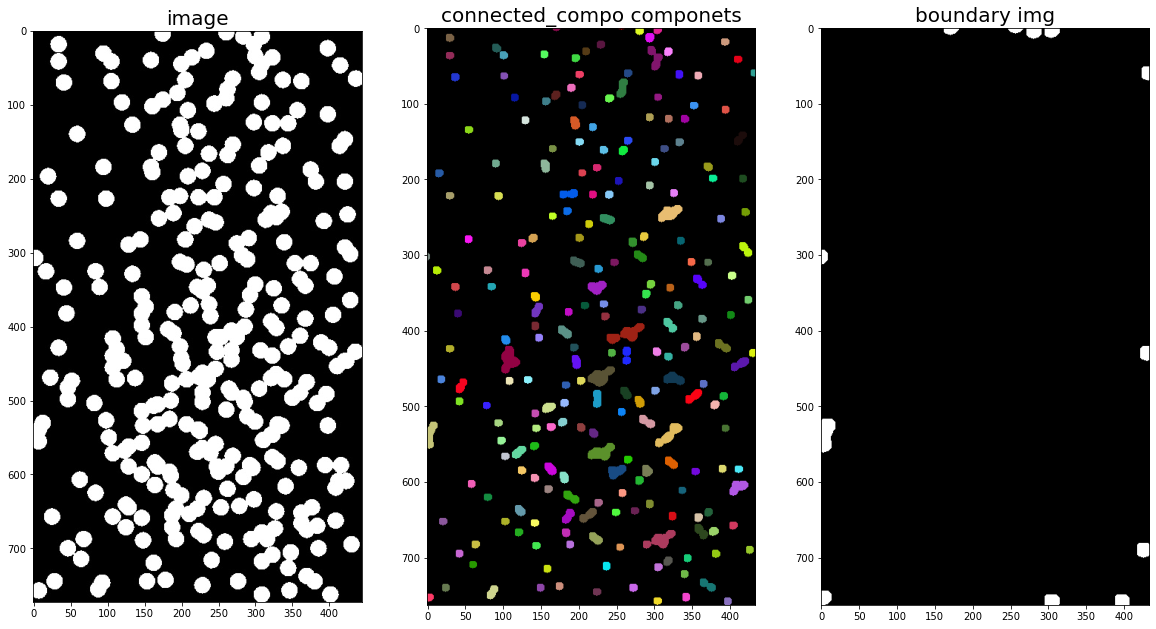

In [5]:
img = cv2.imread('../images/coins.jpg', 0)
win_size = 10
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(win_size,win_size))
img_t = np.where(img >= 127, 1, 0)
img_t = img_t.astype(np.uint8)
#dilation followed by erosion: closing
closed_img = cv2.dilate(cv2.erode(img_t,SE,iterations=2),SE,iterations=1)
connected_compo = connected_component(closed_img, win_size)

boundary_coins = np.zeros(connected_compo.shape)
boundaries_lst = find_boundary_compo(connected_compo)
seg_img = colourise(connected_compo.astype(np.uint8))

for i in range(len(boundaries_lst)):
    boundary_coins[np.where(connected_compo==boundaries_lst[i])] = 1
    
boundary_img = cv2.dilate(boundary_coins,SE,iterations=1)
display_img_arr([img,seg_img,boundary_img], 1, 3, (20, 20), ['image','connected_compo componets','boundary img'])

### Find the coins which overlap
**logic** if the count of each component is higher than the area of a single coin means it is overlapping

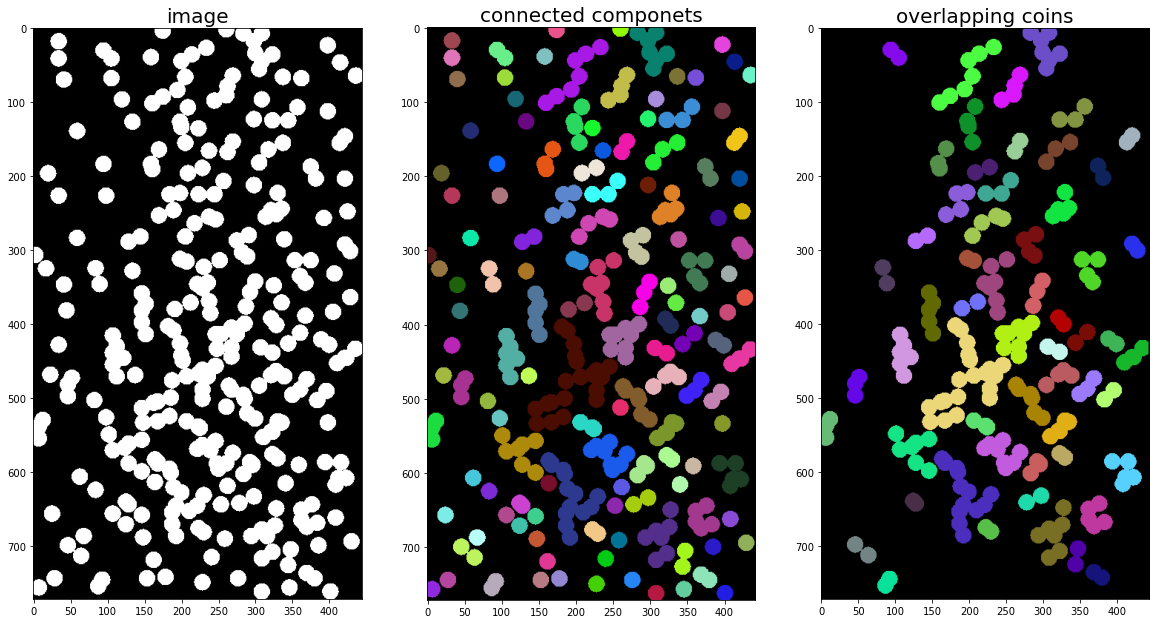

In [6]:
coins_t = np.where(img >= 127, 1, 0).astype(np.uint8)
connected = connected_component(coins_t, 3).astype(np.uint8)
coloured = colourise(connected)

unique, counts = np.unique(connected, return_counts=True)

overlap_coins = np.zeros(img.shape)
nonoverlap_coins = np.zeros(img.shape)
for i in range(len(unique)):
    u = unique[i]
    c = counts[i]
    
    if c > 452:
        if u != 0: 
            overlap_coins[np.where(connected==u)] = u
    else:
        if u != 0: 
            nonoverlap_coins[np.where(connected==u)] = u
            
overlap_coins = overlap_coins.astype(np.uint8)
seg_overlap = colourise(overlap_coins)

display_img_arr([img,coloured,seg_overlap], 1, 3, (20, 20), ['image','connected componets','overlapping coins'])


### Find the coins which donot overlap

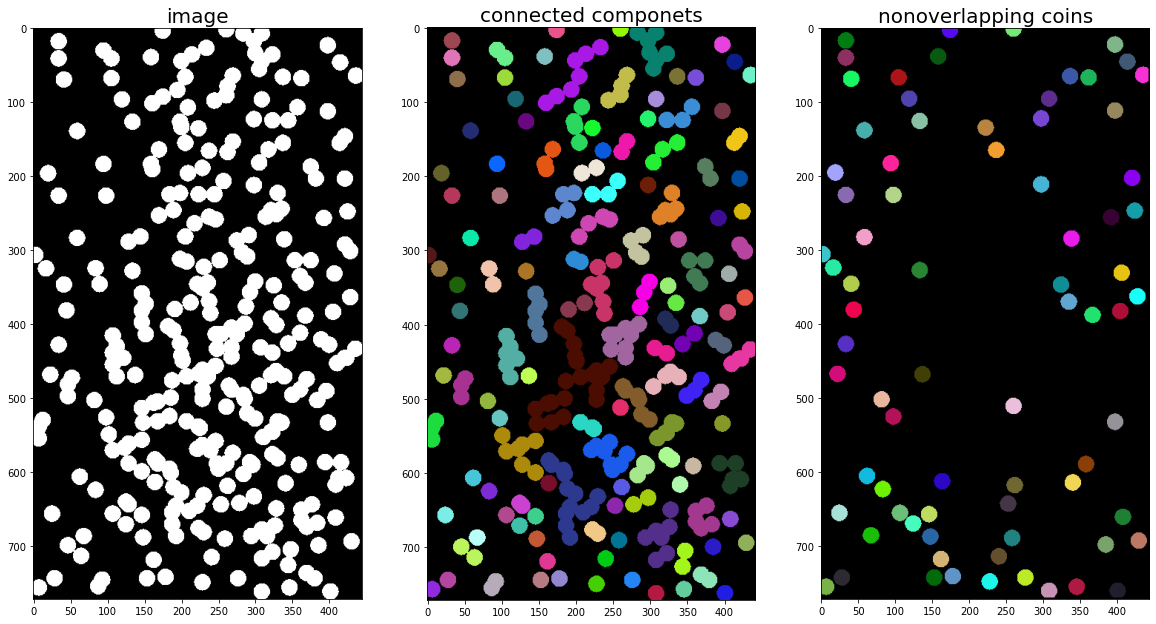

In [7]:
nonoverlap_coins = nonoverlap_coins.astype(np.uint8)
coloured_nonoverlap = colourise(nonoverlap_coins)
display_img_arr([img,coloured,coloured_nonoverlap], 1, 3, (20, 20), ['image','connected componets','nonoverlapping coins'])
